**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
y_pred

array([1])

Saving figure perceptron_iris_plot


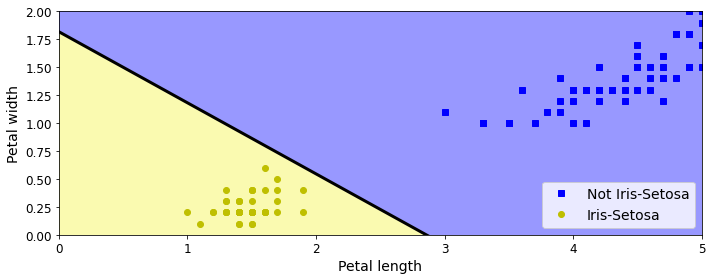

In [5]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


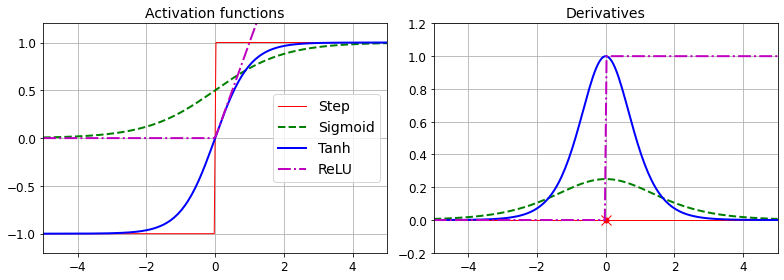

In [7]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [8]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

In [9]:
(z >= 0).astype(z.dtype)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

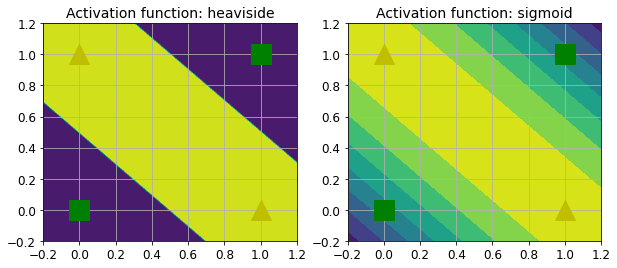

In [10]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

#Building a contor plot of MLP with these 2 activation functions

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
tf.__version__

'2.0.0'

In [13]:
keras.__version__

'2.2.4-tf'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [50]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 4s 1us/step


In [61]:
type(X_train_full)

numpy.ndarray

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [53]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [54]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [56]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

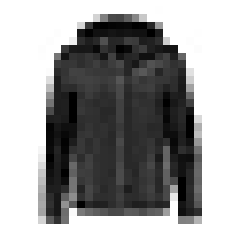

In [59]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [63]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [64]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [65]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


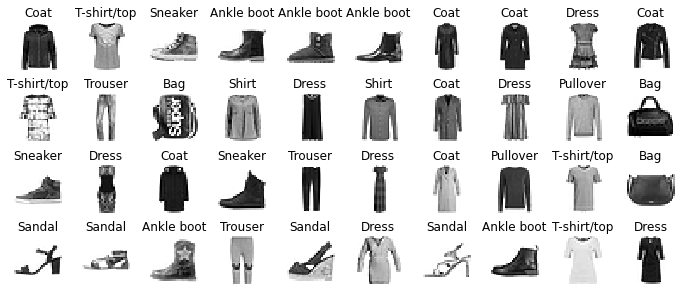

In [67]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [80]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [81]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [82]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [83]:
model.layers

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


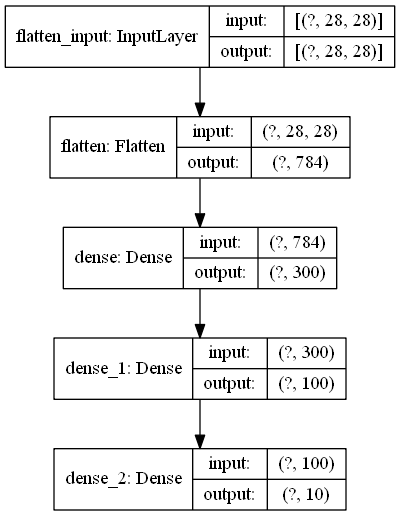

In [86]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [88]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [89]:
model.get_layer(hidden1.name) is hidden1

True

In [90]:
weights, biases = hidden1.get_weights()

In [92]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [97]:
weights.shape

(784, 300)

In [98]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [99]:
biases.shape

(300,)

In [100]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [101]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 7s 134us/sample - loss: 0.7228 - accuracy: 0.7623 - val_loss: 0.5304 - val_accuracy: 0.8162
Epoch 2/30
55000/55000 [==============================] - 5s 92us/sample - loss: 0.4837 - accuracy: 0.8321 - val_loss: 0.4498 - val_accuracy: 0.8444
Epoch 3/30
55000/55000 [==============================] - 5s 93us/sample - loss: 0.4379 - accuracy: 0.8472 - val_loss: 0.4172 - val_accuracy: 0.8552
Epoch 4/30
55000/55000 [==============================] - 5s 92us/sample - loss: 0.4126 - accuracy: 0.8554 - val_loss: 0.3900 - val_accuracy: 0.8650
Epoch 5/30
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3928 - accuracy: 0.8627 - val_loss: 0.3957 - val_accuracy: 0.8624
Epoch 6/30
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3775 - accuracy: 0.8669 - val_loss: 0.3735 - val_accuracy: 0.8742
Epoch 7/30
55000/55000 [==============================] 

In [102]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [103]:
print(history.epoch)
#Why do we use this anyway???

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [108]:
#history.history will give values of these in the 30 epochs
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


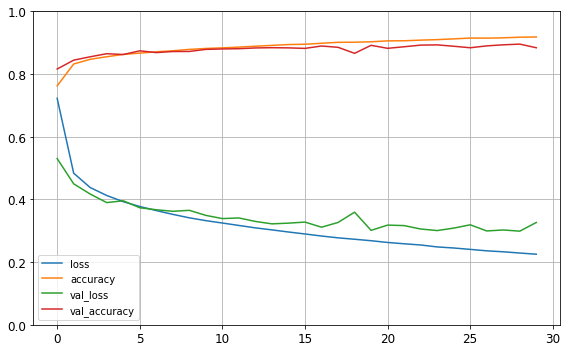

In [109]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [110]:
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3610996503472328, 0.8681]

In [111]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [114]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1], dtype=int64)

In [115]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [46]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


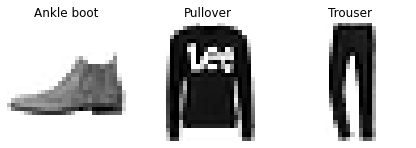

In [116]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [117]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [119]:
X_train.shape

(11610, 8)

In [120]:
np.random.seed(42)
tf.random.set_seed(42)

In [121]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 96us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/20
11610/11610 [==============================] - ETA: 0s - loss: 0.711 - 1s 59us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/20
11610/11610 [==============================] - 1s 52us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/20
11610/11610 [==============================] - 1s 52us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/20
11610/11610 [==============================] - 1s 52us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/20
11610/11610 [==============================] - 1s 54us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 1s 55us/sampl

In [122]:
history.history.keys() # No accuracy here, since this is regression

dict_keys(['loss', 'val_loss'])

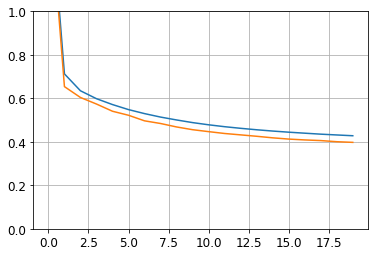

In [123]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [126]:
y_pred

array([[0.36892918],
       [1.6819053 ],
       [3.0886497 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [127]:
np.random.seed(42)
tf.random.set_seed(42)

In [130]:
X_train.shape

(11610, 8)

In [134]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [132]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [140]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 99us/sample - loss: 1.8614 - val_loss: 1.3700
Epoch 2/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.7270 - val_loss: 0.6471
Epoch 3/20
11610/11610 [==============================] - 1s 61us/sample - loss: 0.6476 - val_loss: 0.6401
Epoch 4/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5968 - val_loss: 0.5558
Epoch 5/20
11610/11610 [==============================] - 1s 59us/sample - loss: 0.5564 - val_loss: 0.5095
Epoch 6/20
11610/11610 [==============================] - 1s 61us/sample - loss: 0.5241 - val_loss: 0.4764
Epoch 7/20
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4992 - val_loss: 0.4550
Epoch 8/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4805 - val_loss: 0.4409
Epoch 9/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4649 - val_l

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [141]:
np.random.seed(42)
tf.random.set_seed(42)

In [142]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [144]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 91us/sample - loss: 0.4239 - val_loss: 0.3973
Epoch 2/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4210 - val_loss: 0.3883
Epoch 3/20
11610/11610 [==============================] - 1s 61us/sample - loss: 0.4191 - val_loss: 0.4014
Epoch 4/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4184 - val_loss: 0.3847
Epoch 5/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4167 - val_loss: 0.3823
Epoch 6/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4146 - val_loss: 0.3872
Epoch 7/20
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4134 - val_loss: 0.3796
Epoch 8/20
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4108 - val_loss: 0.3937
Epoch 9/20
11610/11610 [==============================] - 1s 60us/sample - loss: 0.4112 - val_l

Adding an auxiliary output for regularization:

In [146]:
np.random.seed(42)
tf.random.set_seed(42)

In [147]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [148]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [149]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 119us/sample - loss: 2.1329 - main_output_loss: 1.9166 - aux_output_loss: 4.0719 - val_loss: 2.2885 - val_main_output_loss: 1.5657 - val_aux_output_loss: 8.7861
Epoch 2/20
11610/11610 [==============================] - 1s 73us/sample - loss: 0.8910 - main_output_loss: 0.6989 - aux_output_loss: 2.6202 - val_loss: 1.4258 - val_main_output_loss: 0.6285 - val_aux_output_loss: 8.5972
Epoch 3/20
11610/11610 [==============================] - 1s 67us/sample - loss: 0.7397 - main_output_loss: 0.6064 - aux_output_loss: 1.9374 - val_loss: 1.3894 - val_main_output_loss: 0.5941 - val_aux_output_loss: 8.5417
Epoch 4/20
11610/11610 [==============================] - 1s 65us/sample - loss: 0.6746 - main_output_loss: 0.5684 - aux_output_loss: 1.6301 - val_loss: 1.3275 - val_main_output_loss: 0.6028 - val_aux_output_loss: 7.8451
Epoch 5/20
11610/11610 [==============================] - 1s 63us/

In [150]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

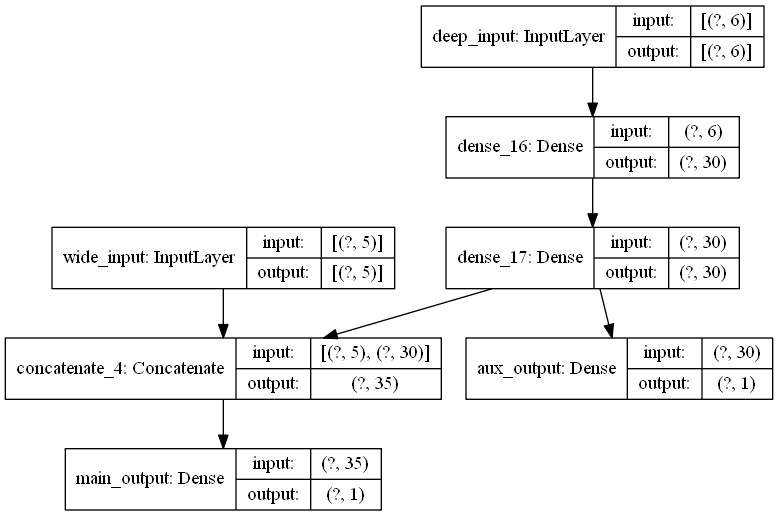

In [151]:
keras.utils.plot_model(model, "WideAndDeepFunctionalAPI_model.png", show_shapes=True)

# The subclassing API

In [152]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [153]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 126us/sample - loss: 2.2968 - output_1_loss: 2.1826 - output_2_loss: 3.3166 - val_loss: 3.0093 - val_output_1_loss: 1.5519 - val_output_2_loss: 16.1139
Epoch 2/10
11610/11610 [==============================] - 1s 69us/sample - loss: 0.9760 - output_1_loss: 0.8529 - output_2_loss: 2.0834 - val_loss: 1.9290 - val_output_1_loss: 0.7524 - val_output_2_loss: 12.5119
Epoch 3/10
11610/11610 [==============================] - 1s 74us/sample - loss: 0.8288 - output_1_loss: 0.7270 - output_2_loss: 1.7431 - val_loss: 1.6768 - val_output_1_loss: 0.7256 - val_output_2_loss: 10.2305
Epoch 4/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.7637 - output_1_loss: 0.6744 - output_2_loss: 1.5665 - val_loss: 1.4544 - val_output_1_loss: 0.6860 - val_output_2_loss: 8.3638
Epoch 5/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.7227 - output_1_loss

In [154]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [156]:
np.random.seed(42)
tf.random.set_seed(42)

In [157]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [171]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 88us/sample - loss: 0.4388 - val_loss: 0.4122
Epoch 2/10
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4319 - val_loss: 0.4046
Epoch 3/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4256 - val_loss: 0.4065
Epoch 4/10
11610/11610 [==============================] - 1s 60us/sample - loss: 0.4202 - val_loss: 0.3998
Epoch 5/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4157 - val_loss: 0.3970
Epoch 6/10
11610/11610 [==============================] - 1s 60us/sample - loss: 0.4112 - val_loss: 0.3964
Epoch 7/10
11610/11610 [==============================] - 1s 56us/sample - loss: 0.4072 - val_loss: 0.3807
Epoch 8/10
11610/11610 [==============================] - 1s 55us/sample - loss: 0.4040 - val_loss: 0.3778
Epoch 9/10
11610/11610 [==============================] - 1s 55us/sample - loss: 0.4007 - val_l

In [172]:
model.save("my_keras_model.h5")

In [173]:
model = keras.models.load_model("my_keras_model.h5")

In [174]:
model.predict(X_new)

array([[0.5288472],
       [1.8840368],
       [3.3950117]], dtype=float32)

In [175]:
model.save_weights("my_keras_weights.ckpt")

In [176]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [179]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [180]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [181]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 93us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/10
11610/11610 [==============================] - 1s 63us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/10
11610/11610 [==============================] - 1s 64us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/10
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/10
11610/11610 [==============================] - 1s 61us/sample - loss: 0.4586 - val_l

In [182]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 91us/sample - loss: 0.4388 - val_loss: 0.4122
Epoch 2/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.4319 - val_loss: 0.4046
Epoch 3/100
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4256 - val_loss: 0.4065
Epoch 4/100
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4202 - val_loss: 0.3998
Epoch 5/100
11610/11610 [==============================] - 1s 63us/sample - loss: 0.4157 - val_loss: 0.3970
Epoch 6/100
11610/11610 [==============================] - 1s 62us/sample - loss: 0.4112 - val_loss: 0.3964
Epoch 7/100
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4072 - val_loss: 0.3807
Epoch 8/100
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4040 - val_loss: 0.3778
Epoch 9/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.400

In [186]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [187]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10432/11610 [=========================>....] - ETA: 0s - loss: 0.3441
val/train: 1.04
11610/11610 [==============================] - 1s 55us/sample - loss: 0.3455 - val_loss: 0.3609


# TensorBoard

In [188]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [189]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_07_09-20_23_16'

In [190]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [191]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [192]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 107us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/30
11610/11610 [==============================] - 1s 63us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/30
11610/11610 [==============================] - 1s 72us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/30
11610/11610 [==============================] - 1s 63us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/30
11610/11610 [==============================] - 1s 68us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/30
11610/11610 [==============================] - 1s 66us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/30
11610/11610 [==============================] - 1s 73us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/30
11610/11610 [==============================] - 1s 65us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/30
11610/11610 [==============================] - 1s 66us/sample - loss: 0.4586 - val_

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [193]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 8268), started 0:03:00 ago. (Use '!kill 8268' to kill it.)

In [194]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2020_07_09-20_41_23'

In [195]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [196]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [197]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 116us/sample - loss: 0.7860 - val_loss: 3.9608
Epoch 2/30
11610/11610 [==============================] - 1s 75us/sample - loss: 0.4406 - val_loss: 19.3299
Epoch 3/30
11610/11610 [==============================] - 1s 70us/sample - loss: 0.3807 - val_loss: 1.9256
Epoch 4/30
11610/11610 [==============================] - 1s 64us/sample - loss: 0.4085 - val_loss: 0.3695
Epoch 5/30
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3784 - val_loss: 0.3267
Epoch 6/30
11610/11610 [==============================] - 1s 70us/sample - loss: 0.3587 - val_loss: 4.5474
Epoch 7/30
11610/11610 [==============================] - 1s 71us/sample - loss: 0.3898 - val_loss: 0.3186
Epoch 8/30
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3448 - val_loss: 0.3265
Epoch 9/30
11610/11610 [==============================] - 1s 77us/sample - loss: 0.3374 - val

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [199]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [205]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [206]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [212]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [208]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 80us/sample - loss: 1.1815 - val_loss: 20.7837
Epoch 2/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.7013 - val_loss: 0.6646
Epoch 3/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5197 - val_loss: 0.5974
Epoch 4/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.4811 - val_loss: 0.5292
Epoch 5/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.4565 - val_loss: 0.4813
Epoch 6/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.4393 - val_loss: 0.4501
Epoch 7/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.4283 - val_loss: 0.4231
Epoch 8/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.4205 - val_loss: 0.4072
Epoch 9/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.41

In [209]:
mse_test = keras_reg.score(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [210]:
y_pred = keras_reg.predict(X_new)

In [211]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon.

In [213]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 1s 97us/sample - loss: 3.5564 - val_loss: 1.8584
Epoch 2/100
7740/7740 [==============================] - 0s 59us/sample - loss: 1.3350 - val_loss: 0.9421
Epoch 3/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.8579 - val_loss: 0.7273
Epoch 4/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.7340 - val_loss: 0.9321
Epoch 5/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.6951 - val_loss: 0.6364
Epoch 6/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6682 - val_loss: 0.8188
Epoch 7/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.6526 - val_loss: 0.7451
Epoch 8/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6386 - val_loss: 0.6280
Epoch 9/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6251 - val_loss: 0.6979
Epoch 10/100
7740/7740 [==============================] - 

[CV]  learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15, total=  13.2s
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s


7740/7740 [==============================] - 1s 92us/sample - loss: 3.5557 - val_loss: 23.2477
Epoch 2/100
7740/7740 [==============================] - 0s 58us/sample - loss: 1.4772 - val_loss: 10.8630
Epoch 3/100
7740/7740 [==============================] - 0s 57us/sample - loss: 1.0155 - val_loss: 4.4730
Epoch 4/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.8734 - val_loss: 1.5265
Epoch 5/100
7740/7740 [==============================] - 1s 70us/sample - loss: 0.8032 - val_loss: 0.7206
Epoch 6/100
7740/7740 [==============================] - 1s 80us/sample - loss: 0.7550 - val_loss: 1.1635
Epoch 7/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.7167 - val_loss: 2.4032
Epoch 8/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.6855 - val_loss: 4.0540
Epoch 9/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.6591 - val_loss: 5.9448
Epoch 10/100
7740/7740 [==============================] 

[CV]  learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15, total=   7.7s
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 114us/sample - loss: 3.2689 - val_loss: 1.3818
Epoch 2/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.9650 - val_loss: 0.7308
Epoch 3/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6171 - val_loss: 0.5392
Epoch 4/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5491 - val_loss: 0.5124
Epoch 5/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5355 - val_loss: 0.5908
Epoch 6/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.5310 - val_loss: 0.7897
Epoch 7/100
7740/7740 [==============================] - 1s 68us/sample - loss: 0.5344 - val_loss: 0.5654
Epoch 8/100
7740/7740 [==============================] -

[CV]  learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15, total=   7.6s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 95us/sample - loss: 1.4462 - val_loss: 5.1308
Epoch 2/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.6498 - val_loss: 12.7918
Epoch 3/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.6009 - val_loss: 0.5573
Epoch 4/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5603 - val_loss: 2.6121
Epoch 5/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.6319 - val_loss: 151.6779
Epoch 6/100
7740/7740 [==============================] - 0s 57us/sample - loss: 1.7132 - val_loss: 528.7355
Epoch 7/100
7740/7740 [==============================] - 0s 58us/sample - loss: 6.1401 - val_loss: 2334.6791
Epoch 8/100
7740/7740 [==========================

[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   6.5s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 89us/sample - loss: 1.1692 - val_loss: 23.5191
Epoch 2/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.5356 - val_loss: 22.9158
Epoch 3/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.5234 - val_loss: 22.1786
Epoch 4/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5157 - val_loss: 22.7104
Epoch 5/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5119 - val_loss: 19.5439
Epoch 6/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5085 - val_loss: 17.4588
Epoch 7/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5065 - val_loss: 19.9278
Epoch 8/100
7740/7740 [===========================

[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   7.6s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 95us/sample - loss: 1.4012 - val_loss: 22.6568
Epoch 2/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.8933 - val_loss: 74.3529
Epoch 3/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6764 - val_loss: 35.7059
Epoch 4/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.8437 - val_loss: 237.3450
Epoch 5/100
7740/7740 [==============================] - 0s 58us/sample - loss: 3.7140 - val_loss: 400.4507
Epoch 6/100
7740/7740 [==============================] - 0s 56us/sample - loss: 11.2961 - val_loss: 689.5318
Epoch 7/100
7740/7740 [==============================] - 0s 60us/sample - loss: 3.4443 - val_loss: 1111.7923
Epoch 8/100
7740/7740 [=====================

[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   5.6s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 110us/sample - loss: 2.4633 - val_loss: 5.9456
Epoch 2/100
7740/7740 [==============================] - 1s 67us/sample - loss: 1.1215 - val_loss: 1.4347
Epoch 3/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.8125 - val_loss: 0.8367
Epoch 4/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.7208 - val_loss: 0.6798
Epoch 5/100
7740/7740 [==============================] - 1s 71us/sample - loss: 0.6788 - val_loss: 0.6425
Epoch 6/100
7740/7740 [==============================] - 1s 76us/sample - loss: 0.6498 - val_loss: 0.6208
Epoch 7/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.6262 - val_loss: 0.5985
Epoch 8/100
7740/7740 [==============================] -

Epoch 76/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3535 - val_loss: 0.3577
Epoch 77/100
7740/7740 [==============================] - 1s 105us/sample - loss: 0.3528 - val_loss: 0.3833
Epoch 78/100
7740/7740 [==============================] - 1s 120us/sample - loss: 0.3522 - val_loss: 0.3699
Epoch 79/100
7740/7740 [==============================] - 1s 123us/sample - loss: 0.3517 - val_loss: 0.3741
Epoch 80/100
7740/7740 [==============================] - 1s 108us/sample - loss: 0.3510 - val_loss: 0.3822
Epoch 81/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.3505 - val_loss: 0.3607
Epoch 82/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.3498 - val_loss: 0.3636
Epoch 83/100
7740/7740 [==============================] - 1s 115us/sample - loss: 0.3494 - val_loss: 0.3599
Epoch 84/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.3487 - val_loss: 0.3708
3870/1 [========================

[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87, total=  47.9s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 174us/sample - loss: 2.7684 - val_loss: 18.4083
Epoch 2/100
7740/7740 [==============================] - 1s 76us/sample - loss: 1.1143 - val_loss: 15.3327
Epoch 3/100
7740/7740 [==============================] - 1s 72us/sample - loss: 0.8059 - val_loss: 11.0646
Epoch 4/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.7051 - val_loss: 8.1682
Epoch 5/100
7740/7740 [==============================] - 1s 132us/sample - loss: 0.6574 - val_loss: 6.1023
Epoch 6/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.6258 - val_loss: 4.6822
Epoch 7/100
7740/7740 [==============================] - 1s 158us/sample - loss: 0.6006 - val_loss: 3.6827
Epoch 8/100
7740/7740 [==========================

[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87, total=  26.6s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 115us/sample - loss: 2.8290 - val_loss: 4.4146
Epoch 2/100
7740/7740 [==============================] - 1s 83us/sample - loss: 1.1367 - val_loss: 1.1500
Epoch 3/100
7740/7740 [==============================] - 1s 71us/sample - loss: 0.8424 - val_loss: 0.8068
Epoch 4/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.7625 - val_loss: 0.7274
Epoch 5/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.7218 - val_loss: 0.6908
Epoch 6/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.6927 - val_loss: 0.6563
Epoch 7/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.6683 - val_loss: 0.6336
Epoch 8/100
7740/7740 [==============================] 

[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87, total=  49.5s
[CV] learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 118us/sample - loss: 2.3816 - val_loss: 14.5443
Epoch 2/100
7740/7740 [==============================] - 0s 61us/sample - loss: 1.2100 - val_loss: 5.8430
Epoch 3/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.9043 - val_loss: 4.3275
Epoch 4/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.8113 - val_loss: 3.4674
Epoch 5/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.7714 - val_loss: 2.7485
Epoch 6/100
7740/7740 [==============================] - 1s 70us/sample - loss: 0.7425 - val_loss: 2.3965
Epoch 7/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.7204 - val_loss: 2.1100
Epoch 8/100
7740/7740 [==============================]

[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24, total=  36.6s
[CV] learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 107us/sample - loss: 3.7588 - val_loss: 28.7992
Epoch 2/100
7740/7740 [==============================] - 0s 62us/sample - loss: 2.0541 - val_loss: 42.6182
Epoch 3/100
7740/7740 [==============================] - 0s 64us/sample - loss: 1.6147 - val_loss: 37.3708
Epoch 4/100
7740/7740 [==============================] - 0s 61us/sample - loss: 1.3635 - val_loss: 28.7112
Epoch 5/100
7740/7740 [==============================] - 1s 66us/sample - loss: 1.1710 - val_loss: 20.3691
Epoch 6/100
7740/7740 [==============================] - 0s 63us/sample - loss: 1.0281 - val_loss: 14.3878
Epoch 7/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.9283 - val_loss: 10.6283
Epoch 8/100
7740/7740 [=========================

[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24, total=  15.6s
[CV] learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 140us/sample - loss: 2.9155 - val_loss: 4.8947
Epoch 2/100
7740/7740 [==============================] - 0s 57us/sample - loss: 1.2940 - val_loss: 3.0524
Epoch 3/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.9739 - val_loss: 1.9077
Epoch 4/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.8515 - val_loss: 1.3465
Epoch 5/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7859 - val_loss: 0.9787
Epoch 6/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.7436 - val_loss: 0.7981
Epoch 7/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.7132 - val_loss: 0.7103
Epoch 8/100
7740/7740 [==============================]

[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24, total=  51.6s
[CV] learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 126us/sample - loss: 2.1242 - val_loss: 27.5149
Epoch 2/100
7740/7740 [==============================] - 1s 79us/sample - loss: 1.0018 - val_loss: 131.2478
Epoch 3/100
7740/7740 [==============================] - 1s 94us/sample - loss: 1.4620 - val_loss: 194.3883
Epoch 4/100
7740/7740 [==============================] - 0s 61us/sample - loss: 4.2615 - val_loss: 400.2876
Epoch 5/100
7740/7740 [==============================] - 0s 56us/sample - loss: 2.5354 - val_loss: 686.7763
Epoch 6/100
7740/7740 [==============================] - 0s 59us/sample - loss: 8.5730 - val_loss: 1577.7325
Epoch 7/100
7740/7740 [==============================] - 0s 55us/sample - loss: 13.6798 - val_loss: 3490.3959
Epoch 8/100
7740/7740 [================

[CV]  learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2, total=   6.2s
[CV] learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 93us/sample - loss: 1.4717 - val_loss: 13.8555
Epoch 2/100
7740/7740 [==============================] - 1s 72us/sample - loss: 0.5772 - val_loss: 17.0246
Epoch 3/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5518 - val_loss: 18.8021
Epoch 4/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.5369 - val_loss: 20.2835
Epoch 5/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.5277 - val_loss: 19.3474
Epoch 6/100
7740/7740 [==============================] - 1s 68us/sample - loss: 0.5205 - val_loss: 18.4462
Epoch 7/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.5158 - val_loss: 19.6960
Epoch 8/100
7740/7740 [============================

[CV]  learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2, total=   5.9s
[CV] learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 115us/sample - loss: 1.9040 - val_loss: 1.7294
Epoch 2/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5866 - val_loss: 0.8622
Epoch 3/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6039 - val_loss: 12.8725
Epoch 4/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.5834 - val_loss: 1.4582
Epoch 5/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.6221 - val_loss: 3.3088
Epoch 6/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.5511 - val_loss: 11.6689
Epoch 7/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.7116 - val_loss: 29.9577
Epoch 8/100
7740/7740 [==============================]

[CV]  learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2, total=   6.2s
[CV] learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 94us/sample - loss: 1.2466 - val_loss: 39.3874
Epoch 2/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.9034 - val_loss: 356.6109
Epoch 3/100
7740/7740 [==============================] - 1s 75us/sample - loss: 1.9792 - val_loss: 0.7164
Epoch 4/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4649 - val_loss: 0.4108
Epoch 5/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.4134 - val_loss: 1.0029
Epoch 6/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.3971 - val_loss: 1.1990
Epoch 7/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.4032 - val_loss: 5.3809
Epoch 8/100
7740/7740 [==============================] 

[CV]  learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38, total=  10.3s
[CV] learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 125us/sample - loss: 0.8880 - val_loss: 2.6958
Epoch 2/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5231 - val_loss: 0.4678
Epoch 3/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4631 - val_loss: 0.4749
Epoch 4/100
7740/7740 [==============================] - 1s 69us/sample - loss: 0.4359 - val_loss: 0.4024
Epoch 5/100
7740/7740 [==============================] - 1s 80us/sample - loss: 0.4209 - val_loss: 0.4751
Epoch 6/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4118 - val_loss: 0.4977
Epoch 7/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.4057 - val_loss: 0.7345
Epoch 8/100
7740/7740 [==============================] -

[CV]  learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38, total=   7.5s
[CV] learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 104us/sample - loss: 1.1476 - val_loss: 19.1236
Epoch 2/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6004 - val_loss: 43.3496
Epoch 3/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6625 - val_loss: 23.9919
Epoch 4/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6275 - val_loss: 2.5008
Epoch 5/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.4657 - val_loss: 0.4522
Epoch 6/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.4227 - val_loss: 0.4120
Epoch 7/100
7740/7740 [==============================] - 1s 76us/sample - loss: 0.4121 - val_loss: 0.3991
Epoch 8/100
7740/7740 [==============================

[CV]  learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38, total=  28.6s
[CV] learning_rate=0.00030107783636342726, n_hidden=3, n_neurons=21 ..
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 116us/sample - loss: 4.0154 - val_loss: 8.4338
Epoch 2/100
7740/7740 [==============================] - 1s 67us/sample - loss: 2.3190 - val_loss: 7.3895
Epoch 3/100
7740/7740 [==============================] - 1s 72us/sample - loss: 1.6395 - val_loss: 5.5681
Epoch 4/100
7740/7740 [==============================] - 1s 68us/sample - loss: 1.3384 - val_loss: 4.1801
Epoch 5/100
7740/7740 [==============================] - 1s 68us/sample - loss: 1.1802 - val_loss: 2.6829
Epoch 6/100
7740/7740 [==============================] - 1s 74us/sample - loss: 1.0684 - val_loss: 2.1789
Epoch 7/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.9882 - val_loss: 1.7644
Epoch 8/100
7740/7740 [==============================] -

Epoch 76/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.4173 - val_loss: 0.4059
Epoch 77/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.4156 - val_loss: 0.4041
Epoch 78/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4139 - val_loss: 0.4025
Epoch 79/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.4123 - val_loss: 0.4010
Epoch 80/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.4107 - val_loss: 0.4001
Epoch 81/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.4092 - val_loss: 0.3988
Epoch 82/100
7740/7740 [==============================] - 1s 72us/sample - loss: 0.4076 - val_loss: 0.3986
Epoch 83/100
7740/7740 [==============================] - 1s 76us/sample - loss: 0.4063 - val_loss: 0.3969
Epoch 84/100
7740/7740 [==============================] - 1s 76us/sample - loss: 0.4048 - val_loss: 0.3948
Epoch 85/100
7740/7740 [=============

[CV]  learning_rate=0.00030107783636342726, n_hidden=3, n_neurons=21, total=  54.6s
[CV] learning_rate=0.00030107783636342726, n_hidden=3, n_neurons=21 ..
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 120us/sample - loss: 5.0627 - val_loss: 2.9619
Epoch 2/100
7740/7740 [==============================] - 1s 66us/sample - loss: 2.1420 - val_loss: 5.9065
Epoch 3/100
7740/7740 [==============================] - 1s 72us/sample - loss: 1.2787 - val_loss: 10.6548
Epoch 4/100
7740/7740 [==============================] - 1s 67us/sample - loss: 1.0909 - val_loss: 11.2295
Epoch 5/100
7740/7740 [==============================] - 1s 65us/sample - loss: 1.0057 - val_loss: 9.7659
Epoch 6/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.9450 - val_loss: 7.9557
Epoch 7/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.8984 - val_loss: 6.5072
Epoch 8/100
7740/7740 [=============================

[CV]  learning_rate=0.00030107783636342726, n_hidden=3, n_neurons=21, total=  14.2s
[CV] learning_rate=0.00030107783636342726, n_hidden=3, n_neurons=21 ..
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 115us/sample - loss: 4.4054 - val_loss: 3.5453
Epoch 2/100
7740/7740 [==============================] - 1s 72us/sample - loss: 2.5632 - val_loss: 3.0304
Epoch 3/100
7740/7740 [==============================] - 1s 86us/sample - loss: 1.4056 - val_loss: 2.5104
Epoch 4/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.9829 - val_loss: 1.7405
Epoch 5/100
7740/7740 [==============================] - 1s 72us/sample - loss: 0.8388 - val_loss: 1.2852
Epoch 6/100
7740/7740 [==============================] - 1s 79us/sample - loss: 0.7690 - val_loss: 0.9827
Epoch 7/100
7740/7740 [==============================] - 1s 77us/sample - loss: 0.7274 - val_loss: 0.8182
Epoch 8/100
7740/7740 [==============================]

[CV]  learning_rate=0.00030107783636342726, n_hidden=3, n_neurons=21, total=  32.2s
[CV] learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 148us/sample - loss: 1.4786 - val_loss: 32.2154
Epoch 2/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.8372 - val_loss: 0.6056
Epoch 3/100
7740/7740 [==============================] - 1s 71us/sample - loss: 0.5351 - val_loss: 0.4733
Epoch 4/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4868 - val_loss: 0.4441
Epoch 5/100
7740/7740 [==============================] - 1s 69us/sample - loss: 0.4613 - val_loss: 0.4300
Epoch 6/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.4455 - val_loss: 0.4229
Epoch 7/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4345 - val_loss: 0.4182
Epoch 8/100
7740/7740 [==============================

[CV]  learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22, total=   9.5s
[CV] learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 105us/sample - loss: 1.2435 - val_loss: 0.6645
Epoch 2/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5790 - val_loss: 0.9961
Epoch 3/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5141 - val_loss: 1.4106
Epoch 4/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.4821 - val_loss: 1.3241
Epoch 5/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.4607 - val_loss: 1.1473
Epoch 6/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4442 - val_loss: 0.7063
Epoch 7/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4326 - val_loss: 0.5003
Epoch 8/100
7740/7740 [==============================] -

[CV]  learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22, total=   9.5s
[CV] learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 111us/sample - loss: 1.7713 - val_loss: 42.9949
Epoch 2/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.8447 - val_loss: 0.5217
Epoch 3/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5263 - val_loss: 0.4754
Epoch 4/100
7740/7740 [==============================] - 1s 68us/sample - loss: 0.4931 - val_loss: 0.4464
Epoch 5/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.4720 - val_loss: 0.4311
Epoch 6/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.4583 - val_loss: 0.4217
Epoch 7/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.4483 - val_loss: 0.4149
Epoch 8/100
7740/7740 [==============================] 

Epoch 76/100
7740/7740 [==============================] - 1s 70us/sample - loss: 0.3547 - val_loss: 0.3506
Epoch 77/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3581 - val_loss: 0.3511
Epoch 78/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3544 - val_loss: 0.3502
Epoch 79/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3533 - val_loss: 0.3507
Epoch 80/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3532 - val_loss: 0.3487
Epoch 81/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3560 - val_loss: 0.3511
Epoch 82/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3523 - val_loss: 0.3490
Epoch 83/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3510 - val_loss: 0.3586
Epoch 84/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.3508 - val_loss: 0.3584
Epoch 85/100
7740/7740 [=============

[CV]  learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22, total=  49.3s
[CV] learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=49 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 116us/sample - loss: 7.7183 - val_loss: 42.9974
Epoch 2/100
7740/7740 [==============================] - 0s 56us/sample - loss: 5.5359 - val_loss: 27.4340
Epoch 3/100
7740/7740 [==============================] - 0s 62us/sample - loss: 4.0708 - val_loss: 17.4759
Epoch 4/100
7740/7740 [==============================] - 0s 58us/sample - loss: 3.0666 - val_loss: 11.0630
Epoch 5/100
7740/7740 [==============================] - 0s 60us/sample - loss: 2.3733 - val_loss: 7.0741
Epoch 6/100
7740/7740 [==============================] - 0s 56us/sample - loss: 1.8924 - val_loss: 4.5246
Epoch 7/100
7740/7740 [==============================] - 0s 58us/sample - loss: 1.5539 - val_loss: 2.9484
Epoch 8/100
7740/7740 [=============================

[CV]  learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=49, total=  11.6s
[CV] learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=49 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 94us/sample - loss: 7.6322 - val_loss: 25.5267
Epoch 2/100
7740/7740 [==============================] - 0s 60us/sample - loss: 5.6958 - val_loss: 23.8046
Epoch 3/100
7740/7740 [==============================] - 0s 58us/sample - loss: 4.3254 - val_loss: 22.6027
Epoch 4/100
7740/7740 [==============================] - 0s 55us/sample - loss: 3.3442 - val_loss: 21.7543
Epoch 5/100
7740/7740 [==============================] - 0s 60us/sample - loss: 2.6354 - val_loss: 21.1529
Epoch 6/100
7740/7740 [==============================] - 0s 62us/sample - loss: 2.1185 - val_loss: 20.7317
Epoch 7/100
7740/7740 [==============================] - 0s 57us/sample - loss: 1.7388 - val_loss: 20.4422
Epoch 8/100
7740/7740 [==========================

[CV]  learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=49, total=  10.9s
[CV] learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=49 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 96us/sample - loss: 6.1551 - val_loss: 7.6300
Epoch 2/100
7740/7740 [==============================] - 0s 59us/sample - loss: 4.4875 - val_loss: 4.9071
Epoch 3/100
7740/7740 [==============================] - 0s 61us/sample - loss: 3.3694 - val_loss: 3.3167
Epoch 4/100
7740/7740 [==============================] - 0s 58us/sample - loss: 2.6034 - val_loss: 2.3629
Epoch 5/100
7740/7740 [==============================] - 0s 64us/sample - loss: 2.0678 - val_loss: 1.7850
Epoch 6/100
7740/7740 [==============================] - 0s 56us/sample - loss: 1.6876 - val_loss: 1.4380
Epoch 7/100
7740/7740 [==============================] - 0s 54us/sample - loss: 1.4151 - val_loss: 1.2333
Epoch 8/100
7740/7740 [==============================] -

[CV]  learning_rate=0.0003099230412972121, n_hidden=0, n_neurons=49, total=  11.8s
[CV] learning_rate=0.0033625641252688094, n_hidden=2, n_neurons=42 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 141us/sample - loss: 1.3428 - val_loss: 6.6633
Epoch 2/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.6725 - val_loss: 27.2674
Epoch 3/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.7856 - val_loss: 3.9609
Epoch 4/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5327 - val_loss: 0.4810
Epoch 5/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4455 - val_loss: 0.4217
Epoch 6/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.4260 - val_loss: 0.4048
Epoch 7/100
7740/7740 [==============================] - 1s 72us/sample - loss: 0.4130 - val_loss: 0.4006
Epoch 8/100
7740/7740 [==============================]

[CV]  learning_rate=0.0033625641252688094, n_hidden=2, n_neurons=42, total=  42.4s
[CV] learning_rate=0.0033625641252688094, n_hidden=2, n_neurons=42 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 102us/sample - loss: 1.1929 - val_loss: 0.8355
Epoch 2/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.6051 - val_loss: 0.8527
Epoch 3/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5373 - val_loss: 1.2540
Epoch 4/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4919 - val_loss: 1.2976
Epoch 5/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.4619 - val_loss: 0.9909
Epoch 6/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4408 - val_loss: 0.6783
Epoch 7/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4267 - val_loss: 0.4828
Epoch 8/100
7740/7740 [==============================] 

[CV]  learning_rate=0.0033625641252688094, n_hidden=2, n_neurons=42, total=   9.1s
[CV] learning_rate=0.0033625641252688094, n_hidden=2, n_neurons=42 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 102us/sample - loss: 1.1250 - val_loss: 3.1401
Epoch 2/100
7740/7740 [==============================] - 1s 69us/sample - loss: 0.7007 - val_loss: 2.5360
Epoch 3/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.5930 - val_loss: 0.9527
Epoch 4/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5268 - val_loss: 0.8469
Epoch 5/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.4832 - val_loss: 0.4355
Epoch 6/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.4538 - val_loss: 0.4917
Epoch 7/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.4367 - val_loss: 0.4116
Epoch 8/100
7740/7740 [==============================] 

[CV]  learning_rate=0.0033625641252688094, n_hidden=2, n_neurons=42, total=  17.0s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 10.2min finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000024202483C48>, as the constructor either does not set or modifies parameter learning_rate

In [224]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [225]:
type(rnd_search_cv)

sklearn.model_selection._search.RandomizedSearchCV

In [226]:
rnd_search_cv.best_score_

-0.3541940433983141

In [223]:
rnd_search_cv.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [221]:
rnd_search_cv.score(X_test, y_test)

AttributeError: 'RandomizedSearchCV' object has no attribute 'scorer_'

In [219]:
model = rnd_search_cv.best_estimator_.model
model

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [106]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.3065


0.30652404945026074

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Let's load the dataset:

In [14]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [15]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [16]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [17]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

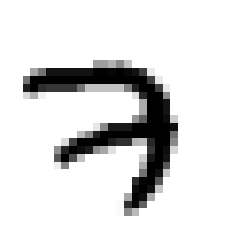

In [18]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [19]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

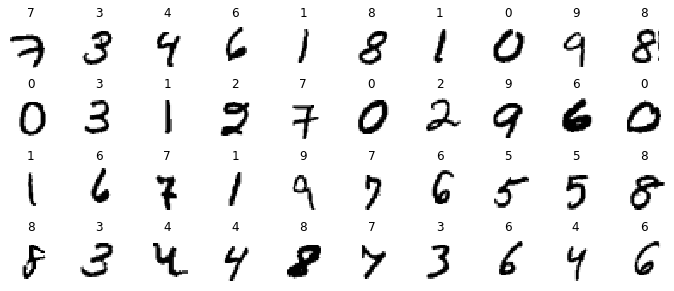

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [32]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [33]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [34]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [36]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 9s 169us/sample - loss: nan - accuracy: 0.5715 - val_loss: nan - val_accuracy: 0.0958


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

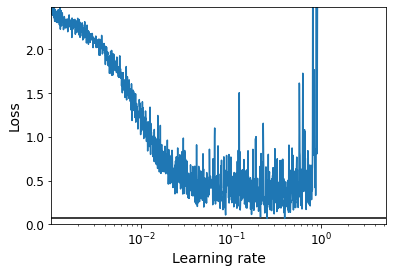

In [37]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently around 3e-1, so let's try using 2e-1 as our learning rate:

In [39]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [41]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [42]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [43]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 9s 157us/sample - loss: 0.2360 - accuracy: 0.9283 - val_loss: 0.0950 - val_accuracy: 0.9712
Epoch 2/100
55000/55000 [==============================] - 8s 137us/sample - loss: 0.0965 - accuracy: 0.9705 - val_loss: 0.0874 - val_accuracy: 0.9764
Epoch 3/100
55000/55000 [==============================] - 8s 139us/sample - loss: 0.0662 - accuracy: 0.9789 - val_loss: 0.0708 - val_accuracy: 0.9796
Epoch 4/100
55000/55000 [==============================] - 8s 145us/sample - loss: 0.0469 - accuracy: 0.9851 - val_loss: 0.0712 - val_accuracy: 0.9792
Epoch 5/100
55000/55000 [==============================] - 8s 138us/sample - loss: 0.0338 - accuracy: 0.9893 - val_loss: 0.0706 - val_accuracy: 0.9784
Epoch 6/100
55000/55000 [==============================] - 7s 136us/sample - loss: 0.0242 - accuracy: 0.9925 - val_loss: 0.0723 - val_accuracy: 0.9808
Epoch 7/100
55000/55000 [====================

In [45]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.07087893806480569, 0.9786]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [48]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5384), started 0:04:28 ago. (Use '!kill 5384' to kill it.)